In [14]:
%load_ext autoreload
%autoreload 2

import os
import sys

from pathlib import Path
from hydra import initialize_config_dir, compose
from hydra.utils import instantiate
from omegaconf import OmegaConf
import tqdm
import torch
import matplotlib.pyplot as plt

from tbfm import film
from tbfm import multisession

DATA_DIR = "/home/mmattb/Projects/opto-coproc/data"
sys.path.append(DATA_DIR)
# imported from JNE project
import dataset
meta = dataset.load_meta(DATA_DIR)

OUT_DIR = "data"  # Local data cache; i.e. not reading from the opto-coproc folder.
EMBEDDING_REST_SUBDIR = "embedding_rest"

conf_dir = Path("./conf").resolve()

# Initialize Hydra with the configuration directory
with initialize_config_dir(config_dir=str(conf_dir), version_base=None):
    # Compose the configuration
    cfg = compose(config_name="config")   # i.e. conf/config.yaml

DEVICE = "cuda:0" #cfg.device
WINDOW_SIZE = cfg.data.trial_len
NUM_HELD_OUT_SESSIONS = cfg.training.num_held_out_sessions

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [15]:
# Okay, now a stim data loader...
d, held_out_session_ids = multisession.load_stim_batched(                                                             
    batch_size=10000,                                                               
    window_size=WINDOW_SIZE,                                                               
    session_subdir="torchraw",                                                     
    data_dir=DATA_DIR,
    # held_in_session_ids=["MonkeyG_20150914_Session1_S1", "MonkeyG_20150915_Session2_S1"],
    # held_in_session_ids=["MonkeyG_20150925_Session2_S1", "MonkeyJ_20160630_Session3_S1", "MonkeyG_20150917_Session1_M1"],
    held_in_session_ids=["MonkeyG_20150925_Session2_S1"],
    num_held_out_sessions=NUM_HELD_OUT_SESSIONS,                                                      
)
data_train, data_test = d.train_test_split(5000, test_cut=2500)

held_in_session_ids = data_train.session_ids

# Gather cached rest embeddings...
embeddings_rest = multisession.load_rest_embeddings(held_in_session_ids, device=DEVICE)

In [4]:
# Customize cfg here...
cfg.tbfm.module.use_film_bases = True
cfg.ae.training.coadapt = True

# Now build...
ms = multisession.build_from_cfg(cfg, data_train, device=DEVICE)
model_optims = multisession.get_optims(cfg, ms)

Building and fitting normalizers...
Building and warm starting AEs...
Building TBFM...
BOOM! Dino DNA!


In [ ]:
# Cleared for takeoff...
embeddings_stim, results = multisession.train_from_cfg(
    cfg,
    ms,
    data_train,
    model_optims,
    embeddings_rest,
    data_test=data_test,
    test_interval=100,
    epochs=12001)

In [7]:
print(results["final_test_r2s"])

{'MonkeyG_20150917_Session1_M1': tensor(0.1986, device='cuda:0'), 'MonkeyG_20150925_Session2_S1': tensor(0.5759, device='cuda:0'), 'MonkeyJ_20160630_Session3_S1': tensor(0.4766, device='cuda:0')}


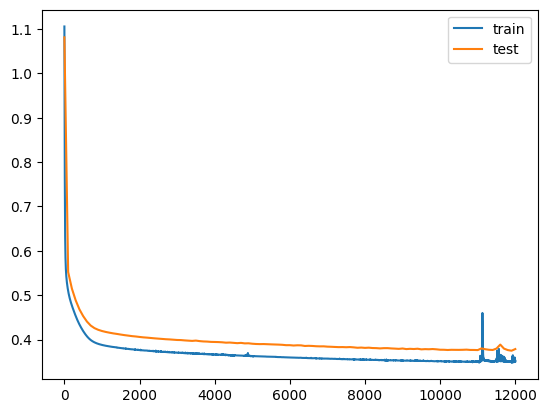

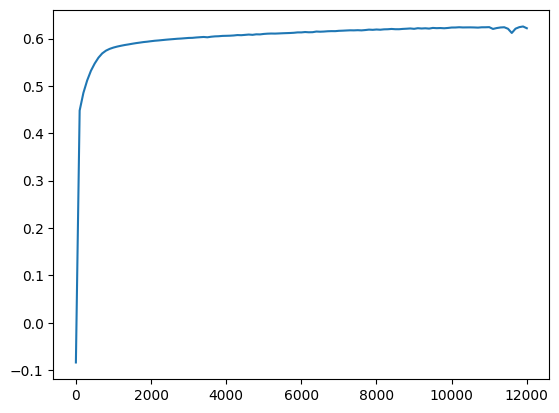

In [7]:
plt.plot(results["train_losses"], label="train")

tx = [t[0] for t in results['test_losses']]
tl = [t[1] for t in results['test_losses']]
plt.plot(tx, tl, label="test")
plt.legend()
plt.show()

tr = [t[1] for t in results['test_r2s']]
plt.plot(tx, tr)
plt.show()

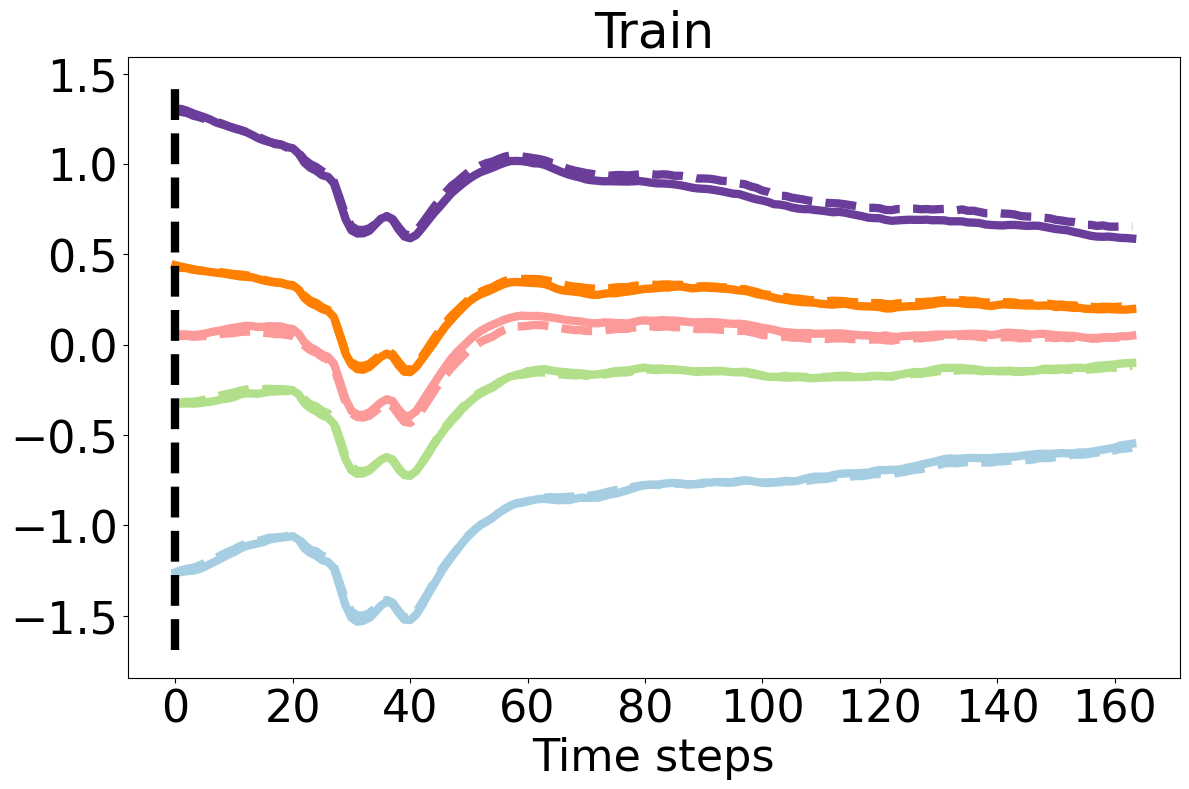

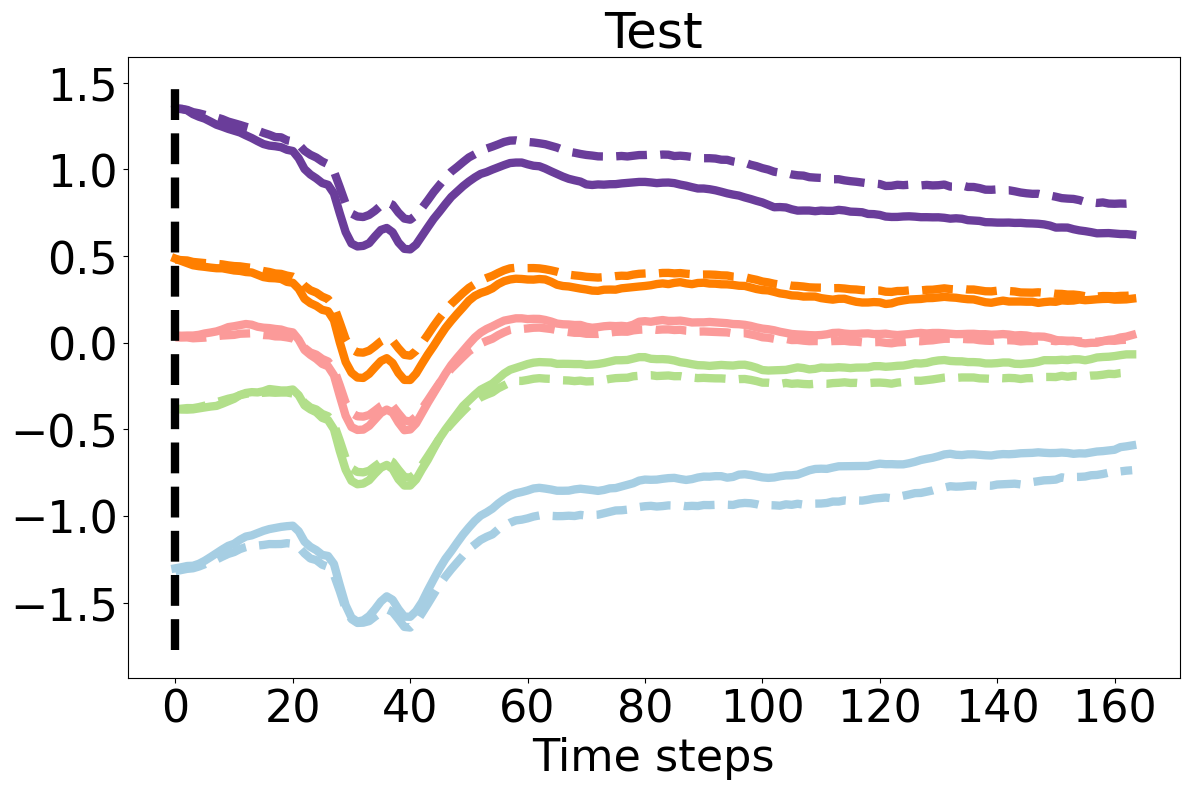

In [8]:
def graph_for_sid(sid, results, cidx=32):
    from tbfm import test
    
    y_hats = results['y_hat'][sid].detach().cpu()
    y_hats_test = results['y_hat_test'][sid].detach().cpu()
    
    y = results['y'][sid].detach().cpu()
    y_test = results['y_test'][sid][2].detach().cpu()
    
    # y_hat_mean = torch.mean(y_hats, dim=0)
    # y_hat_test_mean = torch.mean(y_hats_test, dim=0)
    # y_mean = torch.mean(y, dim=0)
    # y_test_mean = torch.mean(y_test, dim=0)
    
    # bidx = 1000
    
    # plt.plot(y_hat_test_mean[:, cidx], label="hat")
    # plt.plot(y_test_mean[RUNWAY:, cidx], label="y")
    # plt.legend()
    # plt.show()
    test.graph_state_dependency(y, y_hats, title="Train", runway_length=0, ch=cidx)
    test.graph_state_dependency(y_test, y_hats_test, title="Test", runway_length=0, ch=cidx)

graph_for_sid('MonkeyG_20150925_Session2_S1', results, cidx=30)


In [ ]:
# Try:
# * regweight = 0.01, 0.02, 0.05, 0.07, 0.1
# * num bases = 10, 12, 15, 17, 20
# * latent dim = 20, 30, 50, 70
# * grad_clip = (1.0, 10.0)

for regweight in (0.01, 0.02, 0.05, 0.07, 0.1):
    for num_bases in (10, 12, 15, 17, 20):
        for latent_dim in (20, 30, 50, 70):
            for grad_clip in (1.0, 10.0):
                print("---------------", regweight, num_bases, latent_dim, grad_clip)
    
                cfg.tbfm.training.lambda_fro = regweight
                cfg.tbfm.module.num_bases = num_bases
                cfg.latent_dim = latent_dim
                cfg.tbfm.module.use_film_bases = True
                cfg.ae.training.coadapt = True
    
                ms = multisession.build_from_cfg(cfg, data_train, device=DEVICE)
                model_optims = multisession.get_optims(cfg, ms)
                
                embeddings_stim, results = multisession.train_from_cfg(
                    cfg,
                    ms,
                    data_train,
                    model_optims,
                    embeddings_rest,
                    data_test=data_test,
                    test_interval=1000,
                    epochs=12001,
                    grad_clip=grad_clip
                    )
                torch.save(results, f"res_{regweight}_{num_bases}_{latent_dim}_{grad_clip}.torch")

                del model_optims, ms

--------------- 0.01 10 20 1.0
Building and fitting normalizers...
Building and warm starting AEs...
Building TBFM...
BOOM! Dino DNA!
---- 0 0.8581539392471313 0.14049498736858368
---- 1000 0.4228585362434387 0.5773753523826599
---- 2000 0.40967828035354614 0.5906230807304382
---- 3000 0.4043762981891632 0.5959456562995911
---- 4000 0.4011189341545105 0.599209725856781
---- 5000 0.3981289267539978 0.602204442024231
---- 6000 0.39621487259864807 0.6041215062141418
---- 7000 0.39413413405418396 0.6062058210372925
---- 8000 0.3921297788619995 0.6082128882408142
---- 9000 0.39057543873786926 0.6097681522369385
---- 10000 0.3888055682182312 0.6115407347679138
---- 11000 0.38717976212501526 0.6131691336631775
---- 12000 0.387018620967865 0.6133358478546143
Final: 0.387018620967865 0.6133358478546143
--------------- 0.01 10 20 10.0
Building and fitting normalizers...
Building and warm starting AEs...
Building TBFM...
BOOM! Dino DNA!
---- 0 0.8941546082496643 0.10415659844875336
---- 1000 0.42

In [ ]:
d = "hypers_narrow"
f = [os.path.join(d, _f) for _f in os.listdir(d) if _f.startswith("res_") and _f.endswith(".torch")]
res = []
for _f in f:
    r = torch.load(_f)
    res.append((r["final_test_r2"], _f))
res.sort()

for rr in res[-10:]:
    print(rr)

# Dim = 50 or 70; let's try 60 too.
# num_bases in {10,20} that's quite a range
# 0.01 frobenius norm
# Edge to 10.0 grad norm
# Let's sample in closer to those values and get multiple 
# [(0.6266413927078247, 'res_0.01_10_70_1.0.torch'),
#  (0.6285037994384766, 'res_0.01_17_70_1.0.torch'),
#  (0.6323292851448059, 'res_0.01_15_50_1.0.torch'),
#  (0.6324095129966736, 'res_0.01_12_50_1.0.torch'),
#  (0.6349268555641174, 'res_0.01_10_70_10.0.torch'),
#  (0.635103702545166, 'res_0.01_12_70_1.0.torch'),
#  (0.6353448629379272, 'res_0.01_20_50_1.0.torch'),
#  (0.6360984444618225, 'res_0.01_10_50_1.0.torch'),
#  (0.6367953419685364, 'res_0.01_20_70_1.0.torch'),
#  (0.636911928653717, 'res_0.01_15_70_1.0.torch'),
#  (0.6371021866798401, 'res_0.01_17_70_10.0.torch'),
#  (0.6377435922622681, 'res_0.01_10_50_10.0.torch'),
#  (0.6380138993263245, 'res_0.01_15_50_10.0.torch'),
#  (0.6391106247901917, 'res_0.01_17_50_1.0.torch'),
#  (0.639205276966095, 'res_0.01_12_70_10.0.torch'),
#  (0.6398406624794006, 'res_0.01_15_70_10.0.torch'),
#  (0.6398864388465881, 'res_0.01_12_50_10.0.torch'),
#  (0.6402315497398376, 'res_0.01_20_50_10.0.torch'),
#  (0.6415167450904846, 'res_0.01_17_50_10.0.torch'),
#  (0.6483224630355835, 'res_0.01_20_70_10.0.torch')]

In [ ]:
num_repeats = 3
for regweight in (0.005, 0.01):
    for num_bases in (13, 15, 18):
        for latent_dim in (60, 65, 70):
            for grad_clip in (5.0, 10.0, 15.0):
                for ridx in range(num_repeats):
                    print("---------------", regweight, num_bases, latent_dim, grad_clip)
        
                    cfg.tbfm.training.lambda_fro = regweight
                    cfg.tbfm.module.num_bases = num_bases
                    cfg.latent_dim = latent_dim
                    cfg.tbfm.module.use_film_bases = True
                    cfg.ae.training.coadapt = True
        
                    ms = multisession.build_from_cfg(cfg, data_train, device=DEVICE)
                    model_optims = multisession.get_optims(cfg, ms)
                    
                    embeddings_stim, results = multisession.train_from_cfg(
                        cfg,
                        ms,
                        data_train,
                        model_optims,
                        embeddings_rest,
                        data_test=data_test,
                        test_interval=1000,
                        epochs=20001,
                        grad_clip=grad_clip
                        )
                    torch.save(results, f"res_{regweight}_{num_bases}_{latent_dim}_{grad_clip}_{ridx}.torch")
    
                    del model_optims, ms

--------------- 0.005 13 60 5.0
Building and fitting normalizers...
Building and warm starting AEs...
Building TBFM...
BOOM! Dino DNA!
---- 0 1.0191633701324463 -0.02132965810596943
---- 1000 0.40735095739364624 0.5928789973258972
---- 2000 0.39073291420936584 0.6095702052116394
---- 3000 0.3813517093658447 0.6189648509025574
---- 4000 0.37394627928733826 0.6263650059700012
---- 5000 0.3696376383304596 0.63067626953125
---- 6000 0.36021965742111206 0.6400795578956604
---- 7000 0.35872402787208557 0.6415903568267822


In [ ]:
d = "hypers_narrow"
f = [os.path.join(d, _f) for _f in os.listdir(d) if _f.startswith("res_") and _f.endswith(".torch")]
res = []
for _f in f:
    r = torch.load(_f)
    res.append((r["final_test_r2"], _f))
res.sort()

a = {}
for rr in res:
    score, path = rr
    fname = os.path.basename(path)
    toks = fname.split("_")
    regweight, num_bases, latent_dim, grad_clip = toks[1:-1]
    k = (regweight, num_bases, latent_dim, grad_clip)
    if k not in a:
        a[k] = score / 3
    else:
        a[k] += score / 3
        
ranked = [(v, k) for k, v in a.items()]
ranked.sort()
for rr in ranked[-10:]:
    print(rr)

# Set one (hypers_narrow):
# 